In [1]:
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

2025-08-22 13:11:32.927551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-22 13:11:32.927570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/julius/miniconda3/envs/atml/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/julius/miniconda3/envs/atml/lib/python3.9/site-packages/tensorflow_

TensorFlow Version: 2.8.4
Model Maker Version: 0.4.3


In [3]:
import wandb
from wandb.integration.keras import WandbCallback

run = wandb.init(
    entity = 'jfmwi-sailor',
    project = 'MLOPS',
    config = {
        'learning_rate': 0.1,
        'architecture': 'CNN',
        'dataset': 'custom voice data',
        'epochs': 32,
        'batch_size': 16
    }
)

wandb: Currently logged in as: jfmwi (jfmwi-sailor) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
use_custom_dataset = True
if use_custom_dataset:
  # Specify the ZIP file you uploaded:
  #!unzip YOUR-FILENAME.zip
  # Specify the unzipped path to your custom dataset
  # (this path contains all the subfolders with classification names):
  dataset_dir = './data'
  background_dir = './data/background'
  test_dir = './dataset-test'
  sample_dir = './dataset-test'

In [5]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: background
File: /home/julius/Documents/ml_summerschool/dataset-test/background/151bfb79_nohash_1.wav
Sample rate: 16000
Sample length: 16000


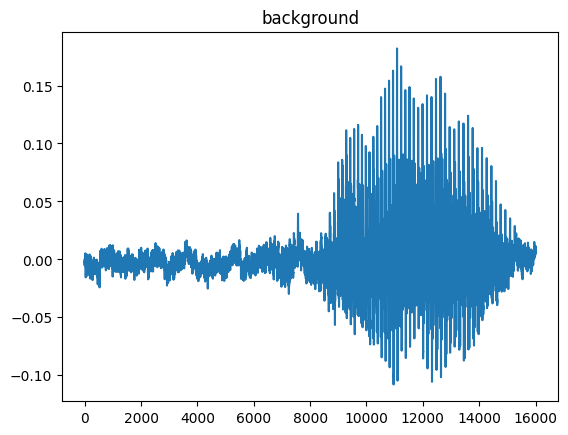

In [6]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

In [7]:
spec = audio_classifier.BrowserFftSpec()
if use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)


INFO:tensorflow:Checkpoints are stored in /tmp/tmp8l4aq_d_


2025-08-22 13:12:11.403770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/julius/miniconda3/envs/atml/lib/python3.9/site-packages/cv2/../../lib64:
2025-08-22 13:12:11.403792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-08-22 13:12:11.403803: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kubuntu): /proc/driver/nvidia/version does not exist
2025-08-22 13:12:11.404010: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_small_audio_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        tf.keras.layers.Conv2D(2, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(2, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

input_shape=(43, 232, 1)
num_classes = 2

model = build_small_audio_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

def add_channel(x, y):
    x = tf.expand_dims(x, axis=-1)  # Shape becomes (43, 232, 1)
    return x, y

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 231, 2)        10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 115, 2)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 114, 2)        18        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 57, 2)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1140)              0         
                                                                 
 dense (Dense)               (None, 5)                

In [9]:
train_ds = train_data.gen_dataset().prefetch(tf.data.AUTOTUNE)
val_ds = validation_data.gen_dataset().prefetch(tf.data.AUTOTUNE)

model.fit(train_ds, validation_data=val_ds,     epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    callbacks=[WandbCallback()])

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/32
   1149/Unknown - 24s 15ms/step - loss: 1.8109 - accuracy: 0.9426

2025-08-22 13:12:45.606494: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/julius/Documents/ml_summerschool/wandb/run-20250822_131204-wuv3m6jl/files/model-best/assets


wandb: Adding directory to artifact (/home/julius/Documents/ml_summerschool/wandb/run-20250822_131204-wuv3m6jl/files/model-best)... Done. 0.0s


1158/1158 [==============================] - 30s 20ms/step - loss: 1.7969 - accuracy: 0.9430 - val_loss: 0.2662 - val_accuracy: 0.9443
Epoch 2/32
1158/1158 [==============================] - 3s 3ms/step - loss: 0.2244 - accuracy: 0.9456 - val_loss: 0.2669 - val_accuracy: 0.9443
Epoch 3/32
1158/1158 [==============================] - 3s 3ms/step - loss: 0.2245 - accuracy: 0.9456 - val_loss: 0.2671 - val_accuracy: 0.9443
Epoch 4/32
1158/1158 [==============================] - 3s 3ms/step - loss: 0.2245 - accuracy: 0.9456 - val_loss: 0.2671 - val_accuracy: 0.9443
Epoch 5/32
1158/1158 [==============================] - 3s 3ms/step - loss: 0.2245 - accuracy: 0.9456 - val_loss: 0.2671 - val_accuracy: 0.9443
Epoch 6/32
1158/1158 [==============================] - 3s 3ms/step - loss: 0.2245 - accuracy: 0.9456 - val_loss: 0.2672 - val_accuracy: 0.9443
Epoch 7/32
1158/1158 [==============================] - 3s 3ms/step - loss: 0.2246 - accuracy: 0.9456 - val_loss: 0.2672 - val_accuracy: 0.9443
E

In [10]:
test_ds = test_data.gen_dataset().prefetch(tf.data.AUTOTUNE)
def convert_labels_to_int(x, y):
    return x, tf.argmax(y, axis=-1)

eval_results = model.evaluate(test_ds)

# Get the metric names from the model
metric_names = model.metrics_names  # e.g., ['loss', 'accuracy']

# Log each metric to W&B
wandb.log({name: value for name, value in zip(metric_names, eval_results)})

717/717 [==============================] - 10s 14ms/step - loss: 0.1386 - accuracy: 0.9721


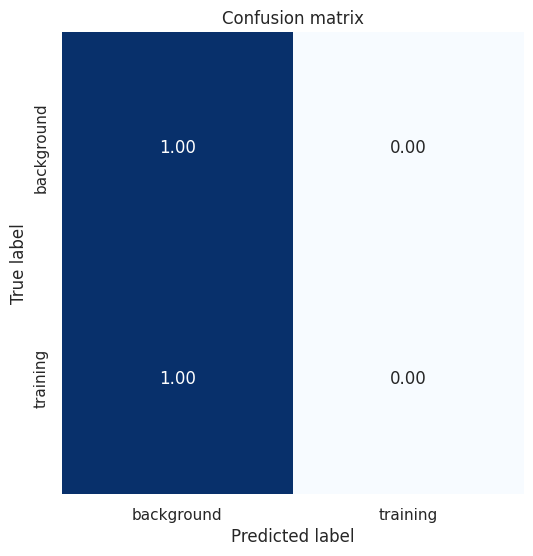

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on test dataset
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch)
    preds_labels = np.argmax(preds, axis=1)

    # Convert one-hot labels to class indices
    true_labels = np.argmax(y_batch.numpy(), axis=1)
    
    y_true.extend(true_labels)
    y_pred.extend(preds_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix using sklearn
confusion = confusion_matrix(y_true, y_pred)

# 3. Visualize confusion matrix (your existing function)
def show_confusion_matrix(confusion, labels):
    confusion_normalized = confusion.astype('float') / confusion.sum(axis=1, keepdims=True)
    sns.set(rc={'figure.figsize':(6,6)})
    sns.heatmap(
        confusion_normalized, xticklabels=labels, yticklabels=labels,
        cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False
    )
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# 4. Provide the class labels in order
class_labels = test_data.index_to_label  # or your list of label names

show_confusion_matrix(confusion, class_labels)


In [12]:
TFLITE_FILENAME = 'custom_model.tflite'
SAVE_PATH = './models'


# Save the Keras model (optional but recommended)
keras_model_path = os.path.join(SAVE_PATH, 'saved_model')
model.save(keras_model_path)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(keras_model_path)
tflite_model = converter.convert()

# Save the TFLite model to file
tflite_model_path = os.path.join(SAVE_PATH, TFLITE_FILENAME)
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'Model exported to {tflite_model_path}')

INFO:tensorflow:Assets written to: ./models/saved_model/assets
Model exported to ./models/custom_model.tflite


2025-08-22 13:16:45.555082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2025-08-22 13:16:45.555104: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2025-08-22 13:16:45.555671: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./models/saved_model
2025-08-22 13:16:45.556717: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2025-08-22 13:16:45.556730: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: ./models/saved_model
2025-08-22 13:16:45.559676: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2025-08-22 13:16:45.592978: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./models/saved_model
2025-08-22 13:16:45.604882: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. 

In [13]:
def generate_header_file(tflite_model_path, header_path):
    """Generate a C header file from a TFLite model."""
    # Read the TFLite model binary
    with open(tflite_model_path, 'rb') as f:
        model_bytes = f.read()
    
    # Convert bytes to hex representation
    hex_lines = []
    for i, byte in enumerate(model_bytes):
        if i % 12 == 0:
            hex_lines.append('\n  ')
        hex_lines.append(f'0x{byte:02x},')
    
    # Write the header file
    with open(header_path, 'w') as f:
        f.write('const unsigned char model[] = {')
        f.write(''.join(hex_lines))
        f.write('\n};\n')
        f.write(f'const unsigned int model_len = {len(model_bytes)};\n')

In [14]:
print("\nConverting model to TFLite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
open("gesture_model.tflite", "wb").write(tflite_model)
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

# Generate header file
os.makedirs('./output', exist_ok=True)
header_path = './output/model.h'
generate_header_file('gesture_model.tflite', header_path)

model_h_size = os.path.getsize(header_path)
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nModel has been converted to model.h in the output directory.")


Converting model to TFLite format...
INFO:tensorflow:Assets written to: /tmp/tmpudxt8o6p/assets
Model is 26032 bytes
Header file, model.h, is 136,743 bytes.

Model has been converted to model.h in the output directory.


2025-08-22 13:16:49.359704: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2025-08-22 13:16:49.359728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2025-08-22 13:16:49.359863: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpudxt8o6p
2025-08-22 13:16:49.360779: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2025-08-22 13:16:49.360793: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpudxt8o6p
2025-08-22 13:16:49.363357: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2025-08-22 13:16:49.394710: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpudxt8o6p
2025-08-22 13:16:49.403675: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 43812 m

In [15]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']

In [16]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(random_audio)

ValueError: The model does not have metadata.